<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/example_notebooks/3_mxrcnn/Example%20-%20Low%20Altitude%20Aerial%20Traffic%20Surveillance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/3_mxrcnn/installation
     
 - Select the right requirements file and run
 
     - cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# Download Dataset

- credits: https://bozcani.github.io/auairdataset
    

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pJ3xfKtHiTdysX5G3dxqKTdGESOBYCxJ" -O data.zip && rm -rf /tmp/cookies.txt

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1boGF0L6olGe_Nu7rd1R8N7YmQErCb0xA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1boGF0L6olGe_Nu7rd1R8N7YmQErCb0xA" -O annotations.zip && rm -rf /tmp/cookies.txt

In [6]:
!mkdir dataset

In [7]:
! unzip -q data.zip
! unzip -q annotations.zip

In [8]:
!mv images dataset/
!mv annotations.json dataset/

# Current annotation

## Dataset Directory Structure

    ./dataset (root_dir)
          |
          |---------/ 
          |         |
          |         |---images 
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations
          |         |----|
          |              |--------------------annotations.json 
          


# Desired annotation - COCO Format

## Dataset Directory Structure

        ./ (root_dir)
          |
          |------dataset (coco_dir) 
          |         |
          |         |---images (set_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations
          |         |----|
          |              |--------------------instances_images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

# Converting annotations to Monk Format

In [9]:
import os
import json
import pandas as pd
from tqdm.notebook import tqdm

with open('dataset/annotations.json') as json_file:
    data = json.load(json_file)
    
classes = data['categories'];

combined = [];
for i in tqdm(range(len(data['annotations']))):
    anno = data['annotations'][i];
    img_file = anno['image_name'];
    wr = "";
    for j in range(len(anno['bbox'])):
        sub_anno = anno['bbox'][j];
        y1 = sub_anno['top'];
        x1 = sub_anno['left'];
        h = sub_anno['height'];
        w = sub_anno['width'];
        label = classes[sub_anno['class']]
        x2 = x1 + w;
        y2 = y1 + h;
        
        wr += str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + " " + label + " ";
        
    wr = wr[:len(wr)-1];
    combined.append([img_file, wr]);
    

df = pd.DataFrame(combined, columns = ['ID', 'Labels'])  
df.to_csv("dataset/train_labels.csv", index=False)

In [10]:
combined[:10]

[['frame_20190829091111_x_0001973.jpg',
  '1098 163 1518 348 Car 1128 421 1521 597 Car 1703 927 1886 1080 Human'],
 ['frame_20190829091111_x_0000334.jpg',
  '976 857 1115 943 Human 624 11 952 221 Car'],
 ['frame_20190829091111_x_0002646.jpg',
  '574 2 934 79 Car 567 289 954 431 Car 565 493 997 664 Car 1044 741 1109 783 Human'],
 ['frame_20190829091111_x_0000249.jpg', '1134 924 1265 1046 Human'],
 ['frame_20190829091111_x_0002140.jpg',
  '653 10 1051 213 Car 1260 629 1342 723 Human'],
 ['frame_20190829091111_x_0003189.jpg',
  '1403 626 1497 695 Human 920 13 1315 189 Car'],
 ['frame_20190829091111_x_0002175.jpg', '1421 548 1547 697 Human'],
 ['frame_20190829091111_x_0003112.jpg',
  '1086 533 1173 602 Human 548 308 927 514 Car 566 81 924 280 Car'],
 ['frame_20190829091111_x_0001125.jpg',
  '81 276 86 286 Truck 314 448 1274 1080 Human'],
 ['frame_20190829091111_x_0000439.jpg', '650 97 917 227 Car 662 0 902 88 Car']]

# Monk Type to COCO Type

In [11]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [12]:
root = "dataset/";
img_dir = "images/";
anno_file = "train_labels.csv";

In [13]:
# Need not change anything below

In [14]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);
    
df = pd.read_csv(input_annotations_path);
columns = df.columns

delimiter = " ";

list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();



100%|██████████| 8/8 [00:00<00:00, 41476.43it/s]


In [15]:
anno

['Bicycle', 'Bus', 'Car', 'Human', 'Motorbike', 'Trailer', 'Truck', 'Van']

In [16]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 32823/32823 [10:54<00:00, 50.15it/s]


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
root_dir = "./";
coco_dir = "dataset";
img_dir = "images"; 

In [4]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [5]:
set_model_params(model_name="resnet50");

In [6]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=10, batch_size=16);

In [7]:
set_output_params(log_interval=100, save_prefix="model_resnet50");

In [8]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [9]:
initialize_rpn_params();
initialize_rcnn_params();

In [10]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [11]:
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_images_roidb.pkl


loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


INFO:root:saving cache ./cache/coco_images_roidb.pkl
INFO:root:coco_images num_images 32823
INFO:root:filter roidb: 32823 -> 32820
INFO:root:coco_images append flipped images to roidb


In [12]:
sym = set_network();

In [ ]:
train(sym, roidb);

# Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./dataset/annotations/classes.txt");

In [4]:
set_model_params(model_name="resnet50", model_path="trained_model/model_resnet50-0006.params");

In [5]:
set_hyper_params(gpus="0", batch_size=1);

In [6]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [7]:
initialize_rpn_params();
initialize_rcnn_params();
sym = set_network();
mod = load_model(sym);

Car
 0.9804394841194153 [810.1753434057367, 533.9287703677662, 978.9313264057665, 687.1937371518607]
Car
 0.8335053324699402 [1829.9447573068526, 0.0, 1918.080073168948, 98.82050181657799]
Car
 0.6389387845993042 [409.83429297768754, 73.06803501388683, 564.9903731151724, 199.6181472632655]
['Car\n', 0.9804394841194153, [810.1753434057367, 533.9287703677662, 978.9313264057665, 687.1937371518607]]


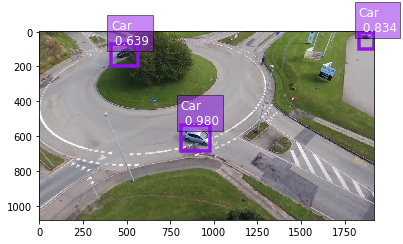

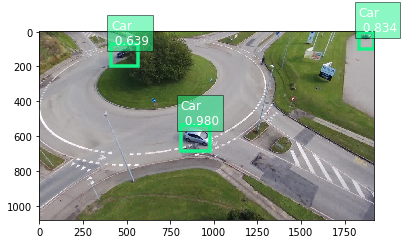

In [14]:
set_output_params(vis_thresh=0.6, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/aerial_surveillance_test/test1.jpg", mod);

Truck
 0.7825750112533569 [1021.4211717766256, 153.36929295994923, 1196.361490950069, 427.45358075918506]
['Truck\n', 0.7825750112533569, [1021.4211717766256, 153.36929295994923, 1196.361490950069, 427.45358075918506]]


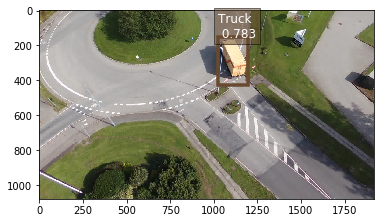

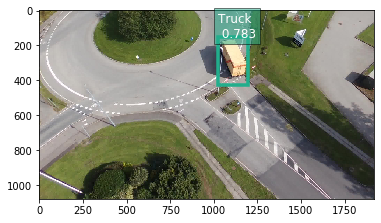

In [15]:
set_output_params(vis_thresh=0.6, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/aerial_surveillance_test/test2.jpg", mod);

Car
 0.971428632736206 [383.04068843996765, 37.836926492192326, 576.1854711984814, 154.89532329160016]
Car
 0.9200920462608337 [64.0400634780908, 170.72517252827348, 216.36736176938484, 309.7623750977468]
['Car\n', 0.971428632736206, [383.04068843996765, 37.836926492192326, 576.1854711984814, 154.89532329160016]]


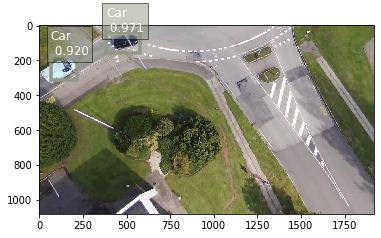

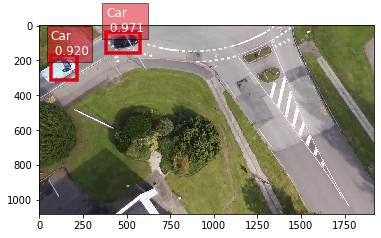

In [16]:
set_output_params(vis_thresh=0.6, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/aerial_surveillance_test/test3.jpg", mod);

Car
 0.7591513991355896 [130.42885751452857, 19.550098402027068, 268.5818657143351, 179.53858106760333]
['Car\n', 0.7591513991355896, [130.42885751452857, 19.550098402027068, 268.5818657143351, 179.53858106760333]]


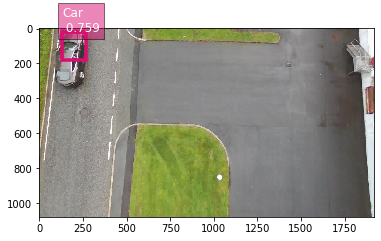

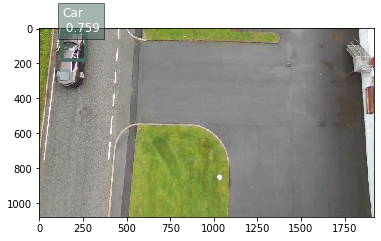

In [21]:
set_output_params(vis_thresh=0.7, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/aerial_surveillance_test/test6.jpg", mod);

Car
 0.6388559341430664 [1092.0715260342226, 333.33106740307113, 1260.867001223259, 520.2996292228557]
Car
 0.5614417791366577 [1306.7960654753138, 356.72362688917644, 1450.737008466225, 522.4340824292786]
Human
 0.560560941696167 [1677.9397905708233, 856.7363412756478, 1814.8989364204, 990.5791784125969]
Van
 0.5846078991889954 [1140.1576606810631, 124.38442857301439, 1432.8960312231457, 315.9208421295487]
['Car\n', 0.6388559341430664, [1092.0715260342226, 333.33106740307113, 1260.867001223259, 520.2996292228557]]


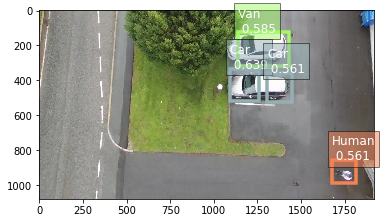

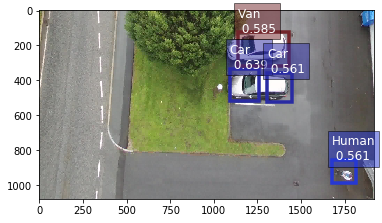

In [27]:
set_output_params(vis_thresh=0.56, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/aerial_surveillance_test/test7.jpg", mod);